# Import

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import scikitplot as skplt
import seaborn as sns

from boruta import BorutaPy
from imblearn.under_sampling import RandomUnderSampler
from scipy import stats
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier, RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from xgboost import XGBClassifier

## Funções de suporte

In [2]:
def jupyter_settings():
    %matplotlib inline
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [15, 7]
    plt.rcParams['font.size'] = 16
    
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
jupyter_settings()

In [3]:
def data_summary(num_attributes):
    # Central tendency - mean, median
    tc1 = pd.DataFrame(num_attributes.apply(np.mean)).T
    tc2 = pd.DataFrame(num_attributes.apply(np.median)).T
    
    # Variability - std, min, max, range, skew, kurtosis
    d1 = pd.DataFrame(num_attributes.apply(min)).T
    d2 = pd.DataFrame(num_attributes.apply(max)).T
    d3 = pd.DataFrame(num_attributes.apply(lambda x: x.max()-x.min())).T
    d4 = pd.DataFrame(num_attributes.apply(np.std)).T
    d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
    d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T
    
    # Concatenate
    s = pd.concat([d1, d2, d3, tc1, tc2, d4, d5, d6]).T.reset_index()
    s.columns = ['columns', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

    return s

In [4]:
def cramerV(x, y):
    cm = pd.crosstab(x, y).values# Confusion matrix
    n = cm.sum()
    r, k = cm.shape
    chi2 = stats.chi2_contingency(cm)[0]# scipy.stats
    phi2 = chi2/n
    
    # Bias correction
    phi2corr = max(0, phi2-(k-1)*(r-1)/(n-1))
    kcorr = k-(k-1)**2/(n-1)
    rcorr = r-(r-1)**2/(n-1)
    
    return np.sqrt(phi2corr/(min(kcorr-1, rcorr-1)))

In [5]:
def precision_recall_k(data):
    '''
    Data is a sorted recommendation dataframe containing columns 
    named recommended and relevant.
    '''
    df = data.copy()
    df['#recommendations'] = df['recommended'].cumsum()
    df['#relevant_recommendations'] = (df['recommended']*df['relevant']).cumsum()
    df['precision@k'] = df['#relevant_recommendations']/df['#recommendations']
    df['recall@k'] = df['#relevant_recommendations']/df['relevant'].sum()
    df['k'] = range(1, len(df)+1)
    return df.loc[:, ['k', 'precision@k', 'recall@k']]

In [6]:
def cross_validation(x, y, model, model_name, kfold = 10, at_k = 1000, proba_threshold = 0.6, verbose = False):
    skf = StratifiedKFold(n_splits = kfold)
    precision_k = []
    recall_k = []
    fold = 1
    for train_index, valid_index in skf.split(x, y):
        if verbose:
            print('Kfold:', fold)
        
        # Data split
        xtrain, xvalid = x.iloc[train_index], x.iloc[valid_index]
        ytrain, yvalid = y.iloc[train_index], y.iloc[valid_index]
        
        # Model training
        model.fit(xtrain, ytrain)
        
        # Prediction
        proba = model.predict_proba(xvalid)
        
        # Performance
        data = pd.DataFrame({'relevant': yvalid, 'proba': proba.T[1]})
        data['recommended'] = data['proba'].apply(lambda x: 0 if x < proba_threshold else 1)
        data.sort_values('proba', ascending = False, inplace = True)
        metrics_k = precision_recall_k(data)
        
        precision_k.append(metrics_k.loc[metrics_k['k'] == at_k, 'precision@k'])
        recall_k.append(metrics_k.loc[metrics_k['k'] == at_k, 'recall@k'])
        
        fold += 1
    return pd.DataFrame({'Model': model_name,
                         'k': at_k,
                         'Precision@k': str(round(np.mean(precision_k), 2)) + ' +- ' + str(round(np.std(precision_k), 2)),
                         'Recall@k': str(round(np.mean(recall_k), 2)) + ' +- ' + str(round(np.std(recall_k), 2))}, index = [0])

In [7]:
def draw_coords(x, y, ax, ls = '--'):
    '''
    Needs fixed axis limits.
    '''
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    cor = ax.lines[-1].get_color()
    ax.vlines(x, ymin, y, ls = ls, color = cor)
    ax.hlines(y, xmin, x, ls = ls, color = cor)

## Importar dados

In [6]:
df_insurance = pd.read_csv('../data/raw/insurance.csv')
df_users = pd.read_csv('../data/raw/users.csv')
df_vehicle = pd.read_csv('../data/raw/vehicle.csv')

In [7]:
aux = df_insurance.merge(df_users, how = 'left', on = 'id')
df_raw = aux.merge(df_vehicle, how = 'left', on = 'id')

## Separação de dados para treino e teste

In [9]:
X_train, X_test, y_train, y_test = train_test_split(df_raw.drop(columns = 'response'), 
                                                    df_raw['response'], 
                                                    test_size = 0.2, 
                                                    random_state = 73)

In [10]:
df_raw = pd.concat([X_train, y_train], axis = 1)

In [11]:
df_test = pd.concat([X_test, y_test], axis = 1)
df_test.to_csv('../data/processed/test.csv', index = False)

# 1 Descrição dos dados

## Data checkpoint

In [12]:
df1 = df_raw.copy()

In [15]:
df1.to_csv('../data/interim/c3_df1.csv', index = False)

In [16]:
df1 = pd.read_csv('../data/interim/c3_df1.csv')

## 1.1 Renomear colunas

In [17]:
df1.columns

Index(['id', 'previously_insured', 'annual_premium', 'vintage', 'gender',
       'age', 'region_code', 'policy_sales_channel', 'driving_license',
       'vehicle_age', 'vehicle_damage', 'response'],
      dtype='object')

## 1.2 Dimensão dos dados

In [18]:
print('Número de linhas: {}'.format(df1.shape[0]))
print('Número de colunas: {}'.format(df1.shape[1]))

Número de linhas: 304887
Número de colunas: 12


## 1.3 Tipos dos dados

In [19]:
df1.dtypes

id                        int64
previously_insured        int64
annual_premium          float64
vintage                   int64
gender                   object
age                       int64
region_code             float64
policy_sales_channel    float64
driving_license           int64
vehicle_age              object
vehicle_damage           object
response                  int64
dtype: object

## 1.4 Tratar NAs

In [20]:
df1.isna().sum()

id                      0
previously_insured      0
annual_premium          0
vintage                 0
gender                  0
age                     0
region_code             0
policy_sales_channel    0
driving_license         0
vehicle_age             0
vehicle_damage          0
response                0
dtype: int64

## 1.5 Estatística descritiva

In [29]:
num_attributes = df1.select_dtypes(include=['int', 'float'])
cat_attributes = df1.select_dtypes(exclude=['int', 'float'])

### 1.5.1 Atributos numéricos

In [30]:
data_summary(num_attributes)

,columns,min,max,range,mean,median,std,skew,kurtosis
0,id,1.0,381109.0,381108.0,190492.669970,190409.0,110005.570323,0.000798,-1.199751
1,previously_insured,0.0,1.0,1.0,0.458042,0.0,0.498236,0.168428,-1.971645
2,annual_premium,2630.0,540165.0,537535.0,30570.406846,31676.0,17231.326432,1.808736,35.069023
3,vintage,10.0,299.0,289.0,154.413183,154.0,83.664460,0.002722,-1.200578
4,age,20.0,85.0,65.0,38.812298,36.0,15.509059,0.673860,-0.562134
5,region_code,0.0,52.0,52.0,26.391004,28.0,13.232461,-0.115071,-0.868571
6,policy_sales_channel,1.0,163.0,162.0,112.048182,134.0,54.199567,-0.900366,-0.969965
7,driving_license,0.0,1.0,1.0,0.997858,1.0,0.046230,-21.538540,461.911732
8,response,0.0,1.0,1.0,0.122596,0.0,0.327973,2.301442,3.296657


### 1.5.2 Atributos categóricos

In [32]:
cat_attributes.apply(lambda x: x.nunique())

gender            2
vehicle_age       3
vehicle_damage    2
dtype: int64

<AxesSubplot:>

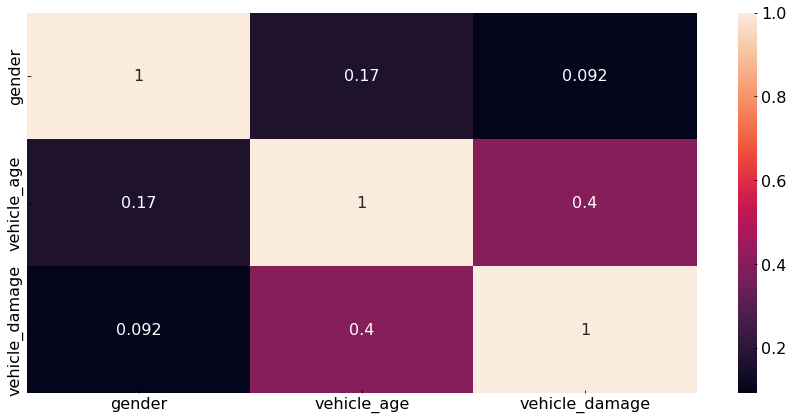

In [36]:
# Cálculo do V de Cramér
a1 = cramerV(cat_attributes['gender'], cat_attributes['gender'])
a2 = cramerV(cat_attributes['gender'], cat_attributes['vehicle_age'])
a3 = cramerV(cat_attributes['gender'], cat_attributes['vehicle_damage'])

a4 = cramerV(cat_attributes['vehicle_age'], cat_attributes['gender'])
a5 = cramerV(cat_attributes['vehicle_age'], cat_attributes['vehicle_age'])
a6 = cramerV(cat_attributes['vehicle_age'], cat_attributes['vehicle_damage'])

a7 = cramerV(cat_attributes['vehicle_damage'], cat_attributes['gender'])
a8 = cramerV(cat_attributes['vehicle_damage'], cat_attributes['vehicle_age'])
a9 = cramerV(cat_attributes['vehicle_damage'], cat_attributes['vehicle_damage'])

# Conjunto final
d = pd.DataFrame({'gender': [a1, a2, a3], 
                  'vehicle_age': [a4, a5, a6], 
                  'vehicle_damage': [a7, a8, a9]})
d.set_index(d.columns, inplace = True)

sns.heatmap(d, annot = True)

# 2 Feature engineering

## Data checkpoint

In [37]:
df2 = df1.copy()

In [38]:
df2.to_csv('../data/interim/c3_df2.csv', index = False)

In [39]:
df2 = pd.read_csv('../data/interim/c3_df2.csv')

## 2.1 Criação das variáveis

In [42]:
df2['vehicle_age'] = df2['vehicle_age'].apply(lambda x: 1 if x == '< 1 Year' else
                                                        2 if x == '1-2 Year' else
                                                        3)
df2['vehicle_damage'] = df2['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)

# 3 Filtragem das variáveis

In [43]:
df3 = df2.copy()

***Nenhuma filtragem***

# 4 Análise exploratória de dados

## Data checkpoint

In [44]:
df4 = df3.copy()

In [45]:
df4.to_csv('../data/interim/c3_df4.csv', index = False)

In [28]:
df4 = pd.read_csv('../data/interim/c3_df4.csv')

## 4.1 Análise univariada

In [46]:
num_attributes = df4.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df4.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])

### 4.1.1 Variável resposta

,response,count,%
0,0,267509,87.740376
1,1,37378,12.259624


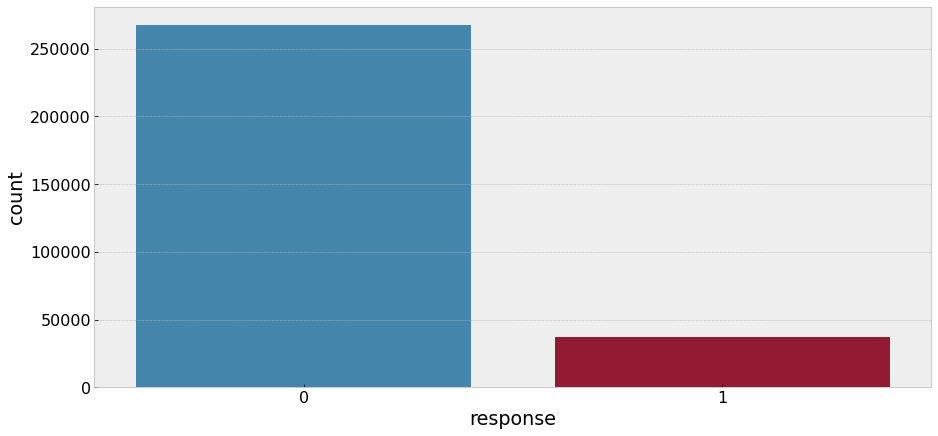

In [47]:
sns.countplot(data = df4, x = 'response')
aux = df4['response'].value_counts().reset_index()
aux.columns = ['response', 'count']
aux['%'] = 100*aux['count']/aux['count'].sum()
aux

### 4.1.2 Variáveis numéricas

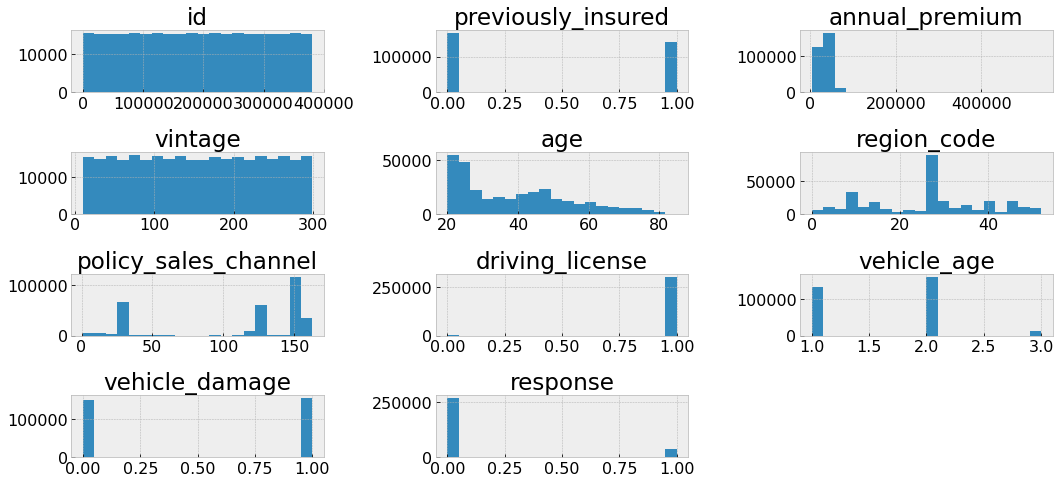

In [48]:
num_attributes.hist(bins = 20)
plt.tight_layout()

### 4.1.3 Variáveis categóricas

<AxesSubplot:xlabel='gender', ylabel='count'>

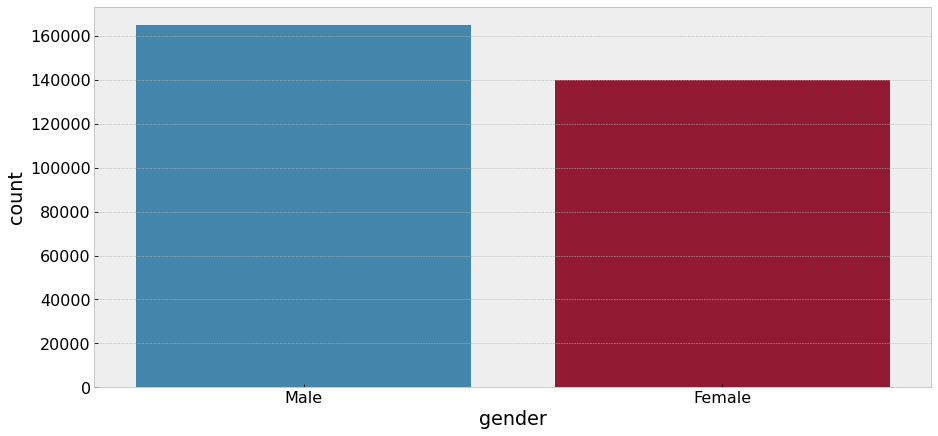

In [49]:
sns.countplot(data = df4, x = 'gender')

## 4.2 Análise bivariada

### 4.2.1 Age

,response,mean_age,median_age
0,0,38.163138,34.0
1,1,43.458237,43.0


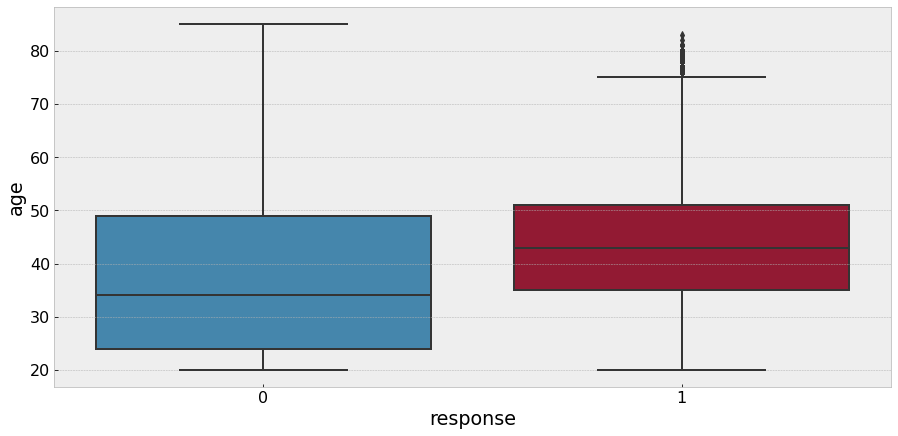

In [50]:
# Age
sns.boxplot(data = df4, x = 'response', y = 'age')
aux1 = df4[['response', 'age']].groupby('response').mean().reset_index()
aux1.columns = ['response', 'mean_age']

aux2 = df4[['response', 'age']].groupby('response').median().reset_index()
aux2.columns = ['response', 'median_age']
aux1.merge(aux2, how = 'inner', on = 'response')

<AxesSubplot:title={'center':'response = 1'}, xlabel='age', ylabel='Count'>

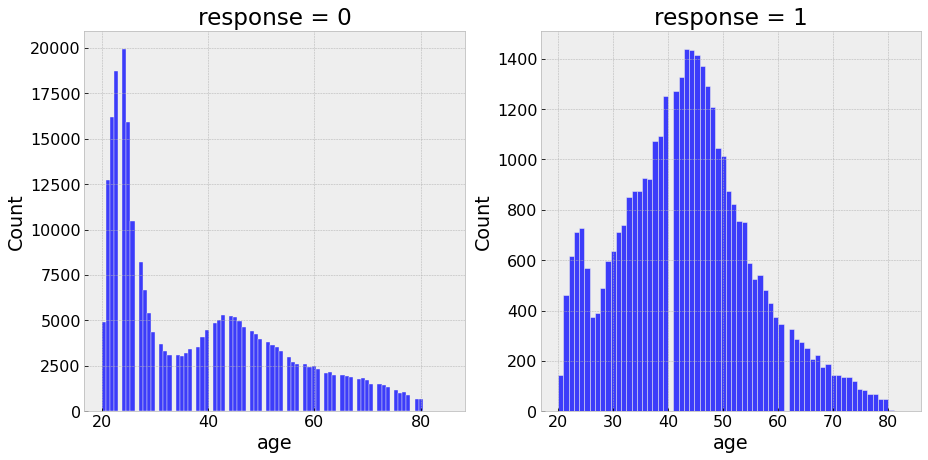

In [51]:
plt.subplot(121)
plt.title('response = 0')
aux0 = df4.loc[df4['response'] == 0, 'age']
sns.histplot(data = aux0)

plt.subplot(122)
plt.title('response = 1')
aux1 = df4.loc[df4['response'] == 1, 'age']
sns.histplot(data = aux1)

### 4.2.2 Annual premium

<AxesSubplot:title={'center':'annual premium < 70k'}, xlabel='response', ylabel='annual_premium'>

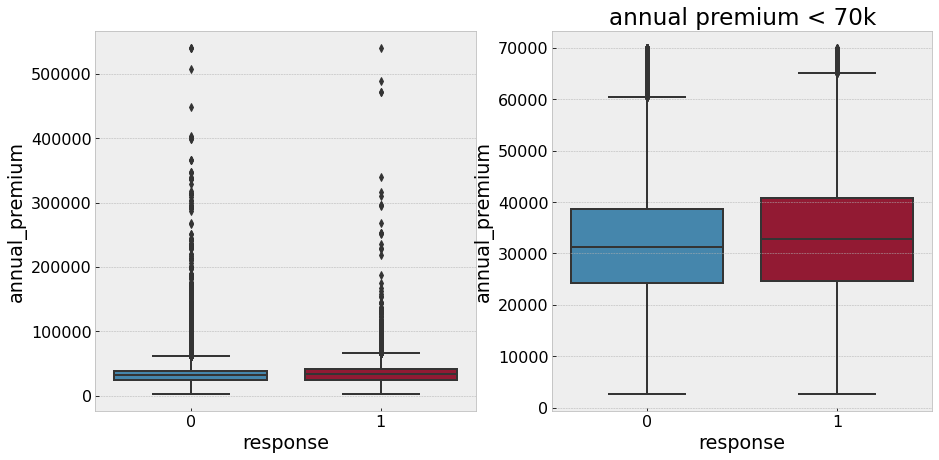

In [52]:
# annual_premium
plt.subplot(121)
sns.boxplot(data = df4, x = 'response', y = 'annual_premium')

plt.subplot(122)
plt.title('annual premium < 70k')
aux = df4[df4['annual_premium'] < 70000]
sns.boxplot(data = aux, x = 'response', y = 'annual_premium')

<AxesSubplot:title={'center':'response = 1'}, xlabel='annual_premium', ylabel='Count'>

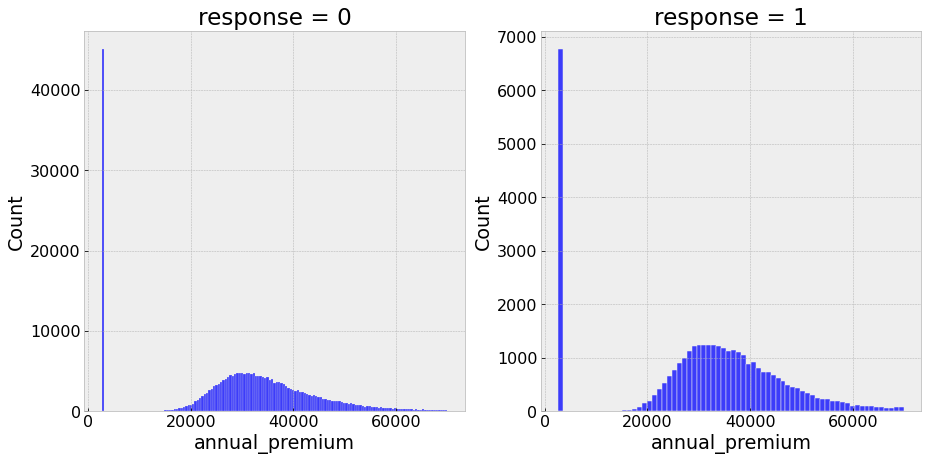

In [53]:
plt.subplot(121)
plt.title('response = 0')
aux0 = aux.loc[aux['response'] == 0, 'annual_premium']
sns.histplot(data = aux0)

plt.subplot(122)
plt.title('response = 1')
aux1 = aux.loc[aux['response'] == 1, 'annual_premium']
sns.histplot(data = aux1)

### 4.2.3 Gender

<AxesSubplot:xlabel='gender', ylabel='count'>

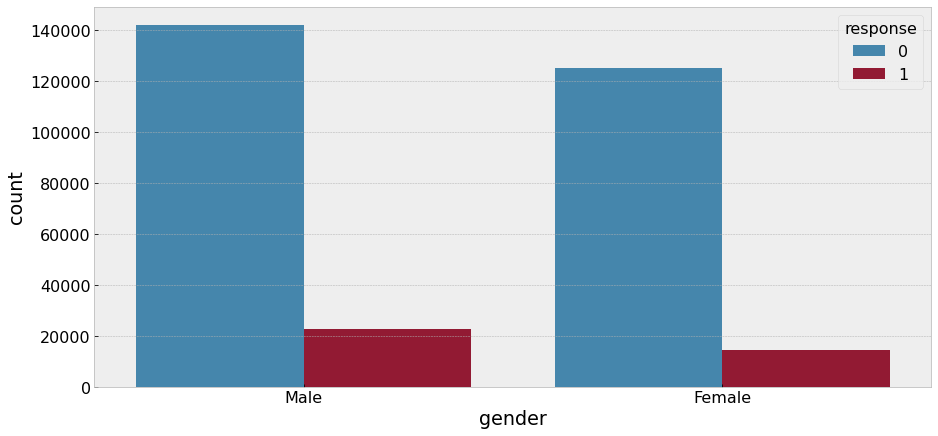

In [54]:
# gender
sns.countplot(data = df4, x = 'gender', hue = 'response')

### 4.2.4 Vintage

<AxesSubplot:xlabel='response', ylabel='vintage'>

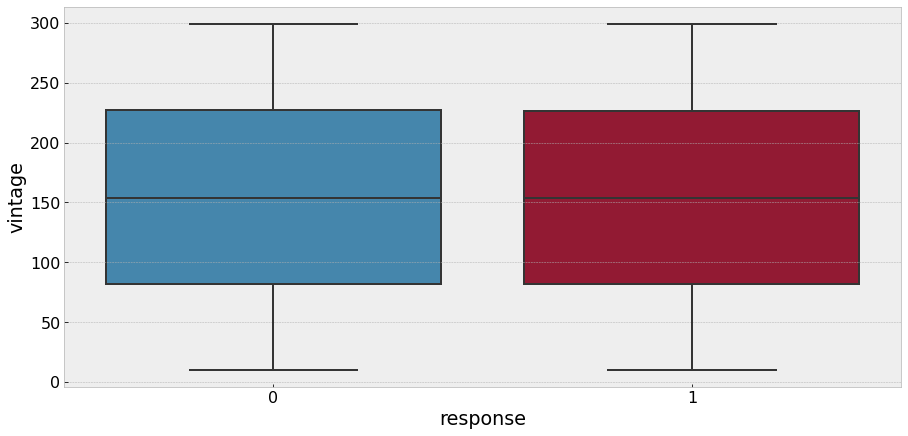

In [55]:
# vintage
sns.boxplot(data = df4, x = 'response', y = 'vintage')

### 4.2.5 Region code

<AxesSubplot:xlabel='region_code'>

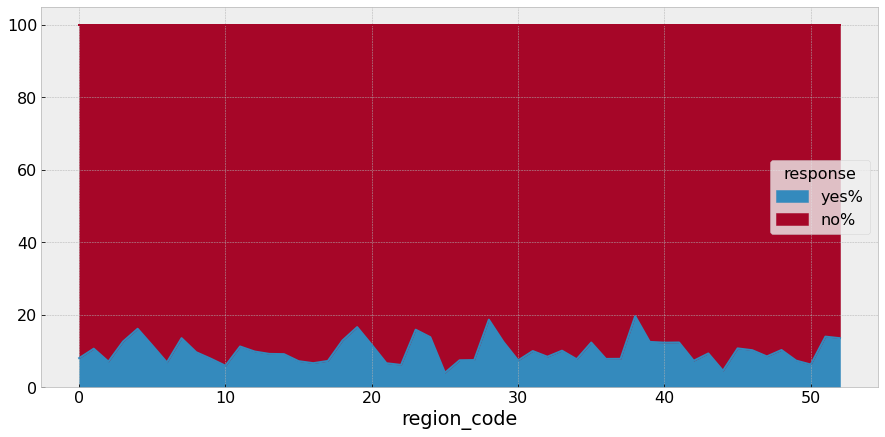

In [56]:
# region_code
tab = pd.crosstab(df4['region_code'], df4['response'])
tab['no%'] = tab.apply(lambda x: 100*x[0]/(x[0]+x[1]), axis = 1)
tab['yes%'] = tab.apply(lambda x: 100*x[1]/(x[0]+x[1]), axis = 1)
tab[['yes%', 'no%']].plot.area()

### 4.2.6 Policy sales channel

<AxesSubplot:xlabel='policy_sales_channel'>

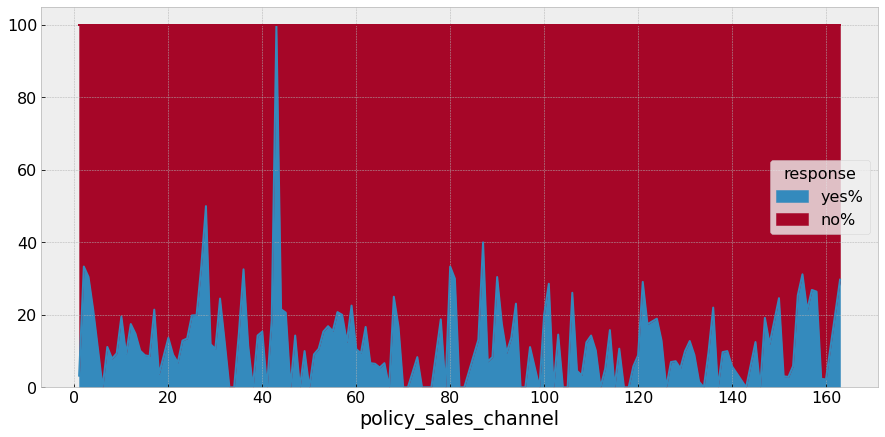

In [57]:
# policy_sales_channel
tab = pd.crosstab(df4['policy_sales_channel'], df4['response'])
tab['no%'] = tab.apply(lambda x: 100*x[0]/(x[0]+x[1]), axis = 1)
tab['yes%'] = tab.apply(lambda x: 100*x[1]/(x[0]+x[1]), axis = 1)
tab[['yes%', 'no%']].plot.area()

### 4.2.7 Previously insured

response,0,1,no%,yes%
previously_insured,,,,
0,127986,37250,77.456486,22.543514
1,139523,128,99.908343,0.091657


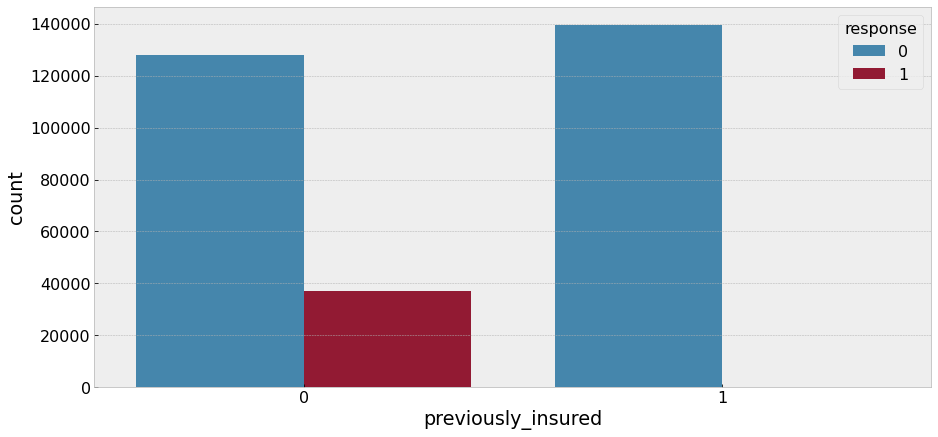

In [58]:
# previously_insured
# 0 não possui seguro de carro
# 1 possui seguro de carro
sns.countplot(data = df4, x = 'previously_insured', hue = 'response')

tab = pd.crosstab(df4['previously_insured'], df4['response'])
tab['no%'] = tab.apply(lambda x: 100*x[0]/(x[0]+x[1]), axis = 1)
tab['yes%'] = tab.apply(lambda x: 100*x[1]/(x[0]+x[1]), axis = 1)
tab

### 4.2.8 Driving license

response,0,1,no%,yes%
driving_license,,,,
0,617,36,94.486983,5.513017
1,266892,37342,87.725895,12.274105


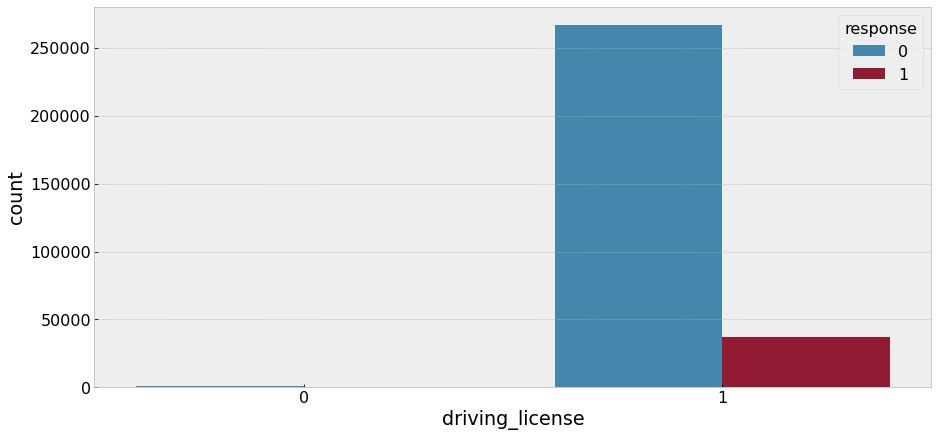

In [59]:
# driving_license
sns.countplot(data = df4, x = 'driving_license', hue = 'response')

tab = pd.crosstab(df4['driving_license'], df4['response'])
tab['no%'] = tab.apply(lambda x: 100*x[0]/(x[0]+x[1]), axis = 1)
tab['yes%'] = tab.apply(lambda x: 100*x[1]/(x[0]+x[1]), axis = 1)
tab

### 4.2.9 Vehicle age

response,0,1,no%,yes%
vehicle_age,,,,
1,126141,5741,95.646866,4.353134
2,132321,27864,82.605113,17.394887
3,9047,3773,70.569423,29.430577


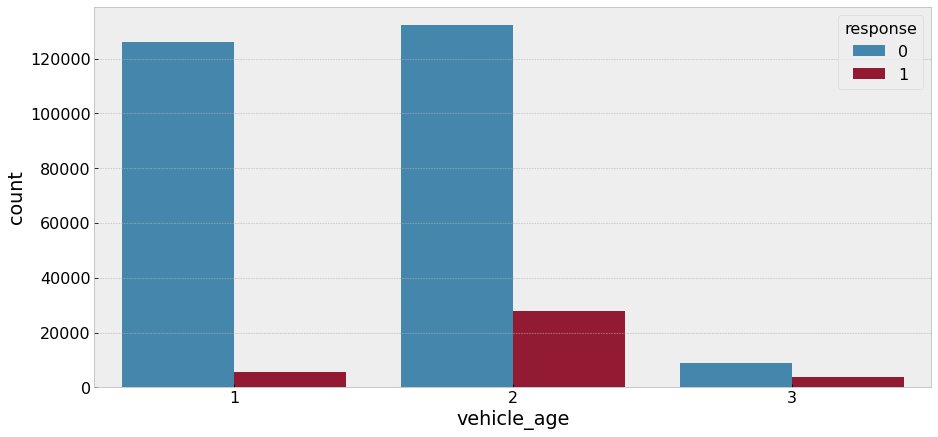

In [60]:
# vehicle_age
sns.countplot(data = df4, x = 'vehicle_age', hue = 'response')

tab = pd.crosstab(df4['vehicle_age'], df4['response'])
tab['no%'] = tab.apply(lambda x: 100*x[0]/(x[0]+x[1]), axis = 1)
tab['yes%'] = tab.apply(lambda x: 100*x[1]/(x[0]+x[1]), axis = 1)
tab

### 4.2.10 Vehicle damage

response,0,1,no%,yes%
vehicle_damage,,,,
0,150149,786,99.479246,0.520754
1,117360,36592,76.231553,23.768447


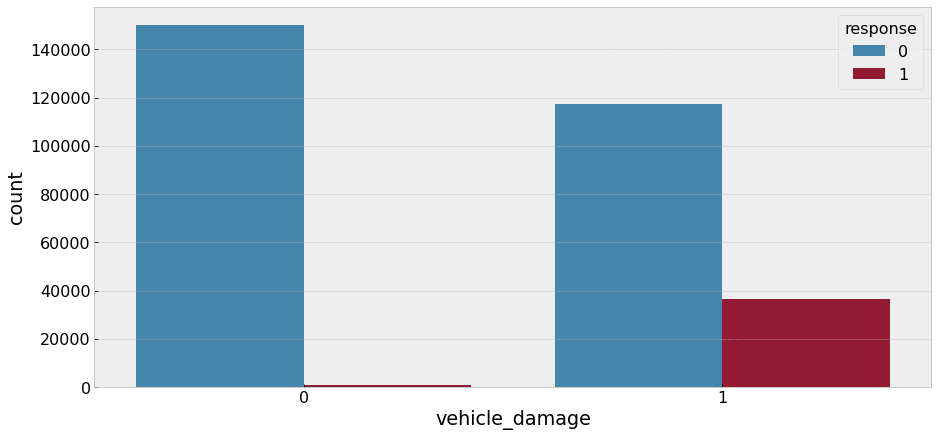

In [61]:
sns.countplot(data = df4, x = 'vehicle_damage', hue = 'response')

tab = pd.crosstab(df4['vehicle_damage'], df4['response'])
tab['no%'] = tab.apply(lambda x: 100*x[0]/(x[0]+x[1]), axis = 1)
tab['yes%'] = tab.apply(lambda x: 100*x[1]/(x[0]+x[1]), axis = 1)
tab

# 5 Preparação dos dados

## Data checkpoint

In [62]:
df5 = df4.copy()

In [64]:
df5.to_csv('../data/interim/c3_df5.csv', index = False)

In [13]:
df5 = pd.read_csv('../data/interim/c3_df5.csv')

## 5.1 Separação de dados para validação

In [14]:
X_train, X_valid, y_train, y_valid = train_test_split(df5.drop(columns = 'response'), 
                                                      df5['response'], 
                                                      test_size = 0.1, 
                                                      random_state = 73)

## 5.2 Balancear os dados

,index,response
0,0,33619
1,1,33619


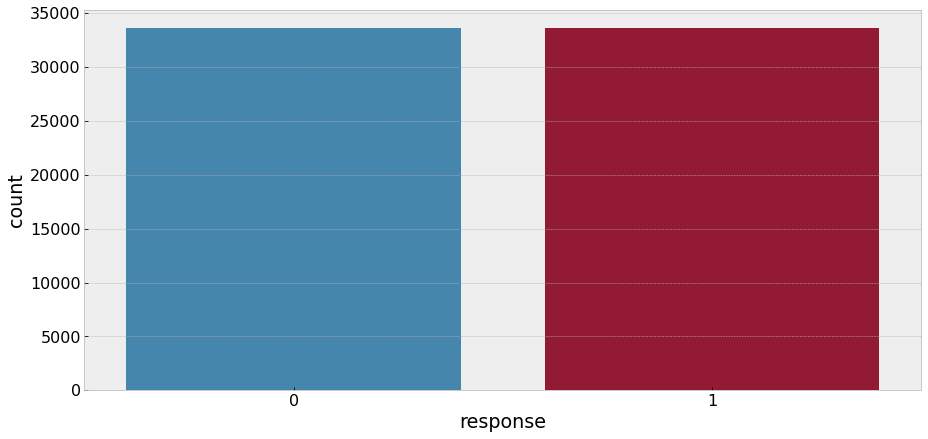

In [15]:
# Under sampling
rus = RandomUnderSampler()
X_res, y_res = rus.fit_resample(X_train, y_train)

sns.countplot(x = y_res)
y_res.value_counts().reset_index()

In [16]:
df5 = pd.concat([X_res, y_res], axis = 1)

## 5.3 Transformação dos dados

### 5.2.1 Normalização

*Nenhuma variável para normalizar*

### 5.2.2 Rescaling

In [17]:
rs = RobustScaler()
mms_vintage = MinMaxScaler()
mms_age = MinMaxScaler()

# annual_premium
df5['annual_premium'] = rs.fit_transform(df5[['annual_premium']].values)
pickle.dump(rs, open('../src/features/annual_premium_scaler.pkl', 'wb'))

# vintage
df5['vintage'] = mms_vintage.fit_transform(df5[['vintage']].values)
pickle.dump(mms_vintage, open('../src/features/vintage_scaler.pkl', 'wb'))

# age
df5['age'] = mms_age.fit_transform(df5[['age']].values)
pickle.dump(mms_age, open('../src/features/age_scaler.pkl', 'wb'))

### 5.2.3 Transformação

In [18]:
# region_code - target encoding
target_region = df5.groupby('region_code').mean()['response']
df5.loc[:, 'region_code'] = df5['region_code'].map(target_region)
pickle.dump(target_region, open('../src/features/region_encoder.pkl', 'wb'))

# policy_sales_channel - target encoding
target_sales = df5.groupby('policy_sales_channel').mean()['response']
df5.loc[:, 'policy_sales_channel'] = df5['policy_sales_channel'].map(target_sales)
pickle.dump(target_sales, open('../src/features/sales_encoder.pkl', 'wb'))

# gender - label encoding
gender_map = {'Male': 1, 'Female': 2}
df5['gender'] = df5['gender'].map(gender_map)
pickle.dump(gender_map, open('../src/features/gender_encoder.pkl', 'wb'))

## 5.4 Preparação dos dados de validação

In [19]:
# annual_premium
X_valid['annual_premium'] = rs.transform(X_valid[['annual_premium']].values)

# vintage
X_valid['vintage'] = mms_vintage.transform(X_valid[['vintage']].values)

# age
X_valid['age'] = mms_age.transform(X_valid[['age']].values)

# region_code - target encoding
X_valid.loc[:, 'region_code'] = X_valid['region_code'].map(target_region)

# policy_sales_channel - target encoding
X_valid.loc[:, 'policy_sales_channel'] = X_valid['policy_sales_channel'].map(target_sales)

# gender - label encoding
X_valid['gender'] = X_valid['gender'].map(gender_map)

In [20]:
df_valid = pd.concat([X_valid, y_valid], axis = 1)

# 6 Seleção das features

## Data checkpoint

In [21]:
df6 = df5.copy()

In [22]:
df6.to_csv('../data/interim/c3_df6.csv', index = False)

In [9]:
df6 = pd.read_csv('../data/interim/c3_df6.csv')

In [22]:
X_train = df6.drop(columns = 'response').copy()
y_train = df6['response'].copy()

## 6.1 Seleção com Boruta

In [29]:
X_train.sample()

,id,previously_insured,annual_premium,vintage,gender,age,region_code,policy_sales_channel,driving_license,vehicle_age,vehicle_damage
32479,34121,0,-1.873274,0.33218,1,0.8,0.440367,0.624203,1,2,1


In [31]:
# Preparar os dados para o Boruta
x_train_b = X_train.values
y_train_b = y_train.values.ravel()

In [32]:
rf = RandomForestRegressor(n_jobs = -1)
boruta = BorutaPy(rf, n_estimators = 'auto', verbose = 2, random_state = 73).fit(x_train_b, y_train_b)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	11
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	9
Iteration: 	9 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	9
Iteration: 	10 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	9
Iteration: 	11 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	9
Iteration: 	12 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	9
Iteration: 	13 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	9
Iteration: 	14 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	9
Iteration: 	15 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	9
Iteration: 	16 / 100
Confirmed: 	1
Tentative: 	1
Rejected: 	9
Iteration:

In [33]:
boruta.support_

array([False, False, False, False, False, False, False, False, False,
       False,  True])

In [36]:
# Features selecionadas
features_selected_boruta = X_train.loc[:,boruta.support_].columns.tolist()

# Features rejeitadas
features_not_selected_boruta = list(np.setdiff1d(X_train.columns, features_selected_boruta))

In [37]:
print('Columns selected by Boruta: \n',features_selected_boruta)
print('\nColumns Not selected by Boruta: \n',features_not_selected_boruta)

Columns selected by Boruta: 
 ['vehicle_damage']

Columns Not selected by Boruta: 
 ['age', 'annual_premium', 'driving_license', 'gender', 'id', 'policy_sales_channel', 'previously_insured', 'region_code', 'vehicle_age', 'vintage']


## 6.2 Importância das features

In [38]:
rf = RandomForestRegressor(n_jobs = -1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

<AxesSubplot:xlabel='importance', ylabel='feature'>

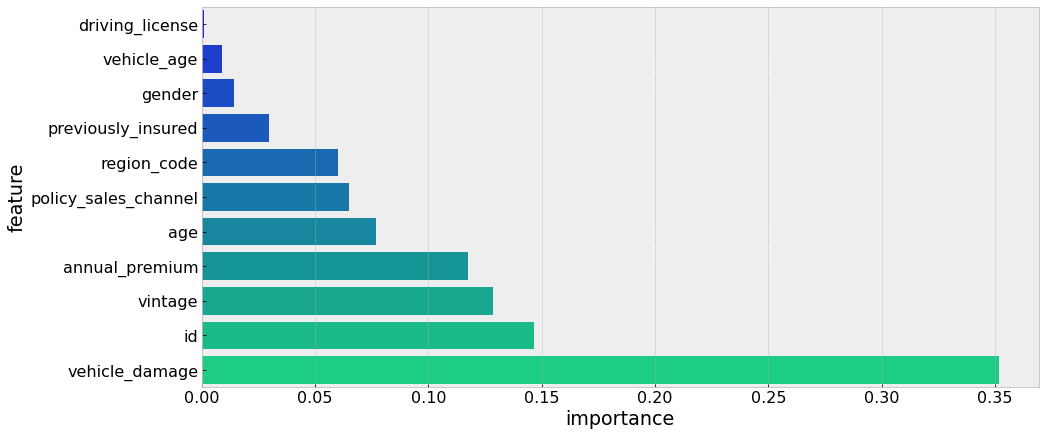

In [39]:
# Feature importance
feat_imp = pd.DataFrame({'feature': X_train.columns,
                         'importance': rf.feature_importances_})
feat_imp = feat_imp.sort_values('importance')
sns.barplot(x = 'importance', y = 'feature', data = feat_imp, palette = 'winter')

## 6.3 Seleção manual

In [8]:
# A inclusão da feature vehicle damage pode gerar vazamento de dados
selected_features = ['vintage', 'annual_premium', 'age', 'region_code', 'policy_sales_channel']

# 7 Machine learning

## Data checkpoint

In [11]:
df7 = df6[selected_features+['response']].copy()

In [12]:
x_train = df7.drop('response', axis = 1)
y_train = df7['response']
x_valid = df_valid[selected_features].copy()
y_valid = df_valid['response']

# Alguns valores de policy_sales_channel aparecem apenas no dataset de teste
x_valid['policy_sales_channel'].fillna(0, inplace = True)

NameError: name 'df_valid' is not defined

## 7.1 Random forest

### 7.1.1 Classificação

,Model,Accuracy,Precision,Recall,f1-score,ROC-AUC
0,Random forest classifier,0.641871,0.216368,0.726523,0.333435,0.678245


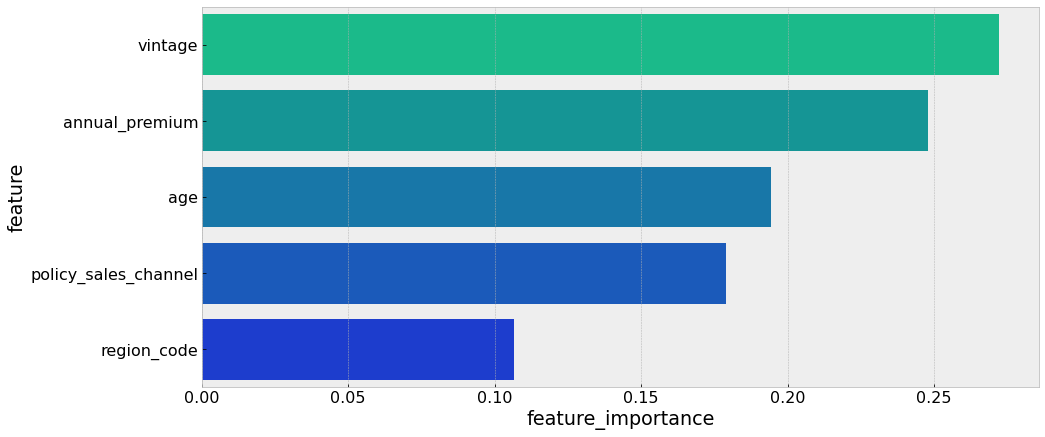

In [48]:
# Model training
rf = RandomForestClassifier(random_state = 73)
rf.fit(x_train, y_train)

# Feature importance
feat_imp = pd.DataFrame({'feature': x_train.columns,
                         'feature_importance': rf.feature_importances_})
feat_imp = feat_imp.sort_values('feature_importance', ascending = False)
sns.barplot(x = 'feature_importance', y = 'feature', data = feat_imp, palette = 'winter_r')

# Prediction
pred_rf = rf.predict(x_valid)

# Performance
rf_performance = pd.DataFrame(['Random forest classifier',
                               metrics.accuracy_score(y_valid, pred_rf),
                               metrics.precision_score(y_valid, pred_rf),
                               metrics.recall_score(y_valid, pred_rf),
                               metrics.f1_score(y_valid, pred_rf),
                               metrics.roc_auc_score(y_valid, pred_rf)]).T
rf_performance.columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'f1-score', 'ROC-AUC']
rf_performance

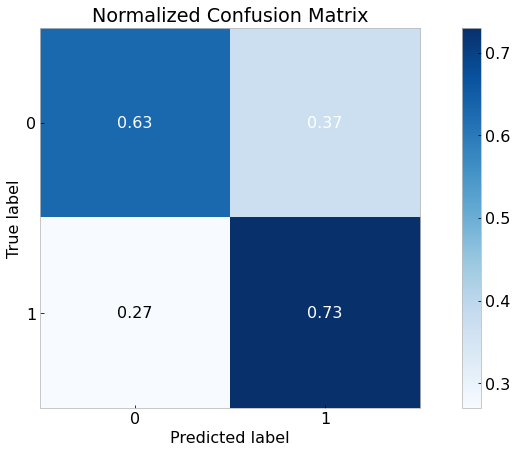

In [49]:
skplt.metrics.plot_confusion_matrix(y_valid, pred_rf, normalize = True);

### 7.1.2 Ranqueamento

In [50]:
# Model training
rf = RandomForestClassifier(random_state = 73)
rf.fit(x_train, y_train)

# Prediction
proba_rf = rf.predict_proba(x_valid)

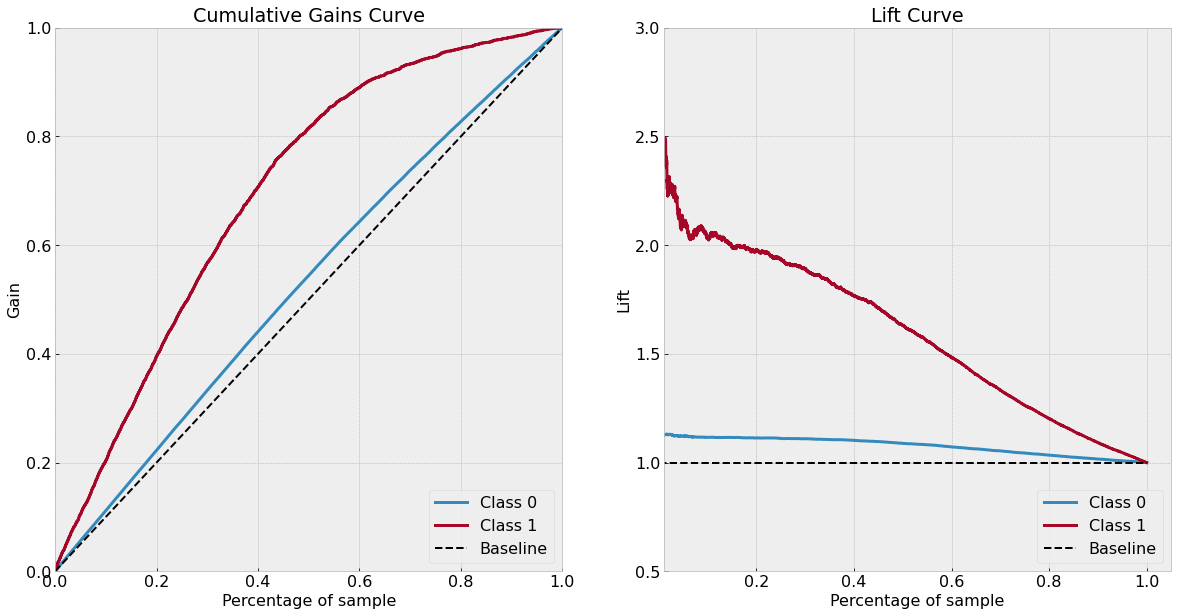

In [51]:
fig, axs = plt.subplots(ncols = 2, figsize = (20, 10))

# Cumulative gain
skplt.metrics.plot_cumulative_gain(y_valid, proba_rf, ax = axs[0])

# Lift curve
skplt.metrics.plot_lift_curve(y_valid, proba_rf, ax = axs[1])
axs[1].set_xlim(left = 0.01)
axs[1].set_ylim((0.5, 3));

In [52]:
data = pd.DataFrame({'relevant': y_valid, 'proba': proba_rf.T[1]})
data['recommended'] = data['proba'].apply(lambda x: 0 if x < 0.6 else 1)
data.sort_values('proba', ascending = False, inplace = True)

metrics_k_rf = precision_recall_k(data)

In [53]:
metrics_k_rf.loc[metrics_k_rf['k'].isin([100, 1000, 10000, 20000])]

,k,precision@k,recall@k
75127,100,0.38000,0.010109
114087,1000,0.27600,0.073424
235055,10000,0.22957,0.595637
64029,20000,0.22957,0.595637


### 7.1.3 Cross-validation

In [54]:
performance_cv_rf = cross_validation(x_train, y_train, 
                                     RandomForestClassifier(random_state = 73), 'Random forest classifier', 
                                     kfold = 10, at_k = 2200, verbose = False)
performance_cv_rf

,Model,k,Precision@k,Recall@k
0,Random forest classifier,2200,0.7 +- 0.01,0.46 +- 0.01


## 7.2 Extra trees

In [55]:
# Model training
et = ExtraTreesClassifier(n_jobs = -1, random_state = 73)
et.fit(x_train, y_train)

# Prediction
proba_et = et.predict_proba(x_valid)

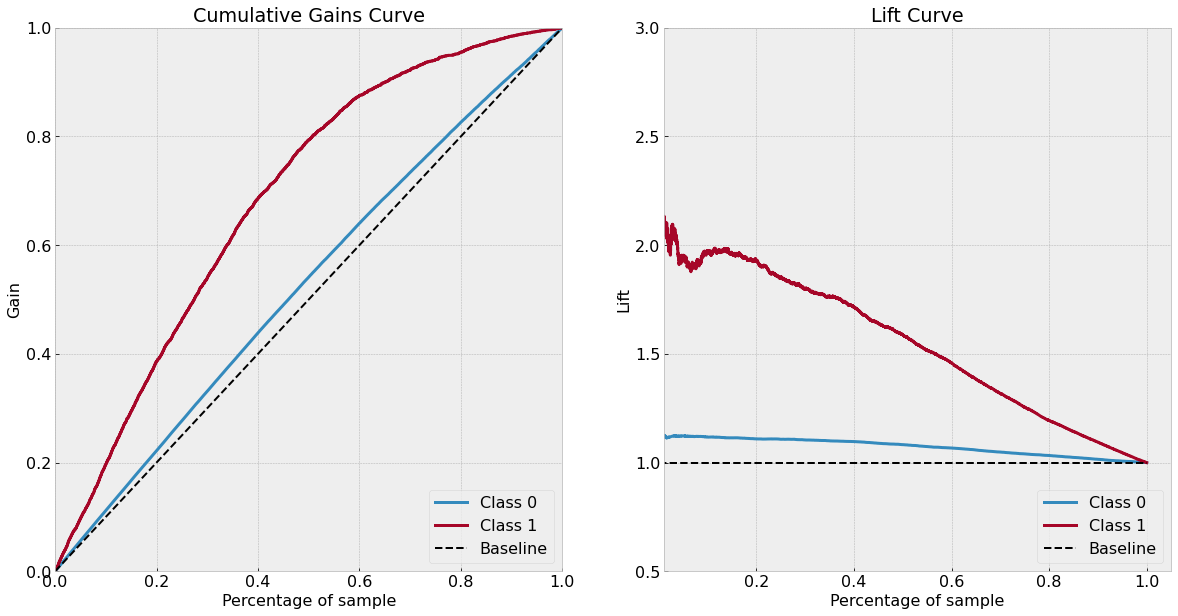

In [56]:
fig, axs = plt.subplots(ncols = 2, figsize = (20, 10))

# Cumulative gain
skplt.metrics.plot_cumulative_gain(y_valid, proba_et, ax = axs[0])

# Lift curve
skplt.metrics.plot_lift_curve(y_valid, proba_et, ax = axs[1])
axs[1].set_xlim(left = 0.01)
axs[1].set_ylim((0.5, 3));

In [57]:
data = pd.DataFrame({'relevant': y_valid, 'proba': proba_et.T[1]})
data['recommended'] = data['proba'].apply(lambda x: 0 if x < 0.6 else 1)
data.sort_values('proba', ascending = False, inplace = True)

metrics_k_et = precision_recall_k(data)

In [58]:
metrics_k_et.loc[metrics_k_et['k'].isin([100, 1000, 10000, 20000])]

,k,precision@k,recall@k
240346,100,0.260000,0.006917
176351,1000,0.252000,0.067039
58158,10000,0.218500,0.581272
40130,20000,0.218731,0.587124


### 7.2.1 Cross-validation

In [59]:
performance_cv_et = cross_validation(x_train, y_train, 
                                     ExtraTreesClassifier(n_jobs = -1, random_state = 73), 'Extra trees classifier', 
                                     kfold = 10, at_k = 2200, verbose = False)
performance_cv_et

,Model,k,Precision@k,Recall@k
0,Extra trees classifier,2200,0.69 +- 0.01,0.45 +- 0.0


## 7.3KNN

In [60]:
# Model training
knn = KNeighborsClassifier(n_neighbors = 10)
knn.fit(x_train, y_train)

# Prediction
proba_knn = knn.predict_proba(x_valid)

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


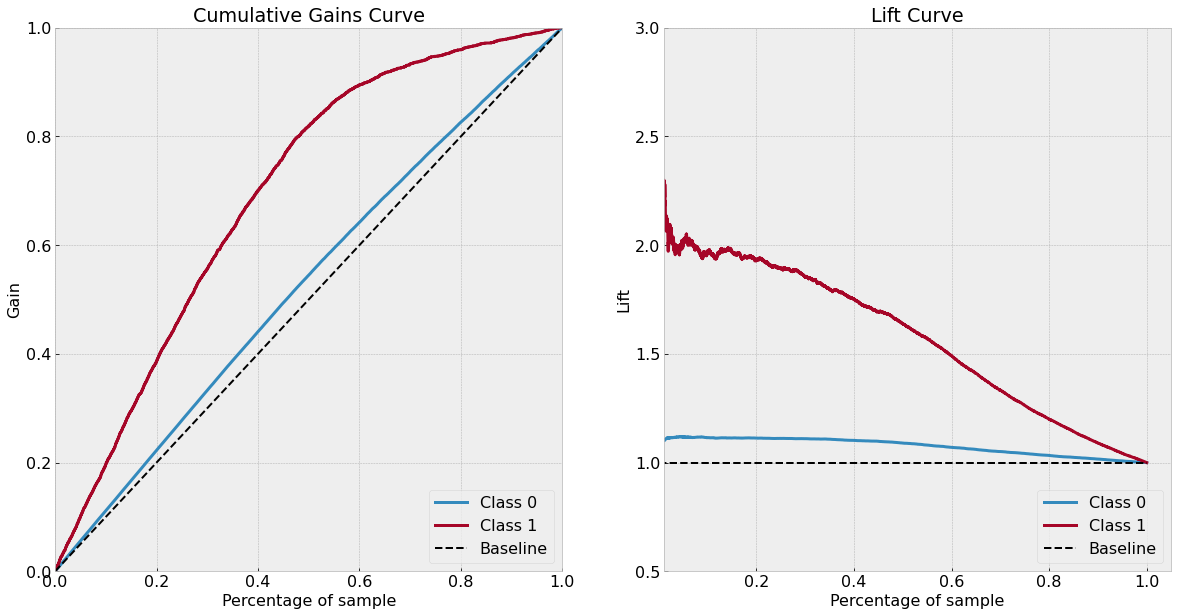

In [61]:
fig, axs = plt.subplots(ncols = 2, figsize = (20, 10))

# Cumulative gain
skplt.metrics.plot_cumulative_gain(y_valid, proba_knn, ax = axs[0])

# Lift curve
skplt.metrics.plot_lift_curve(y_valid, proba_knn, ax = axs[1])
axs[1].set_xlim(left = 0.01)
axs[1].set_ylim((0.5, 3));

In [62]:
data = pd.DataFrame({'relevant': y_valid, 'proba': proba_knn.T[1]})
data['recommended'] = data['proba'].apply(lambda x: 0 if x < 0.6 else 1)
data.sort_values('proba', ascending = False, inplace = True)

metrics_k_knn = precision_recall_k(data)

In [63]:
metrics_k_knn.loc[metrics_k_knn['k'].isin([100, 1000, 10000, 20000])]

,k,precision@k,recall@k
143853,100,0.320000,0.008513
185329,1000,0.253000,0.067305
166379,10000,0.222400,0.591647
220489,20000,0.219851,0.668795


### 7.3.1 Cross-validation

In [64]:
performance_cv_knn = cross_validation(x_train, y_train, 
                                     KNeighborsClassifier(n_neighbors = 10), 'KNN classifier', 
                                     kfold = 10, at_k = 2200, verbose = False)
performance_cv_knn

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but KNeighbo

,Model,k,Precision@k,Recall@k
0,KNN classifier,2200,0.69 +- 0.02,0.45 +- 0.01


## 7.4 Logistic regression

In [65]:
# Model training
lr = LogisticRegression(random_state = 73)
lr.fit(x_train, y_train)

# Prediction
proba_lr = lr.predict_proba(x_valid)

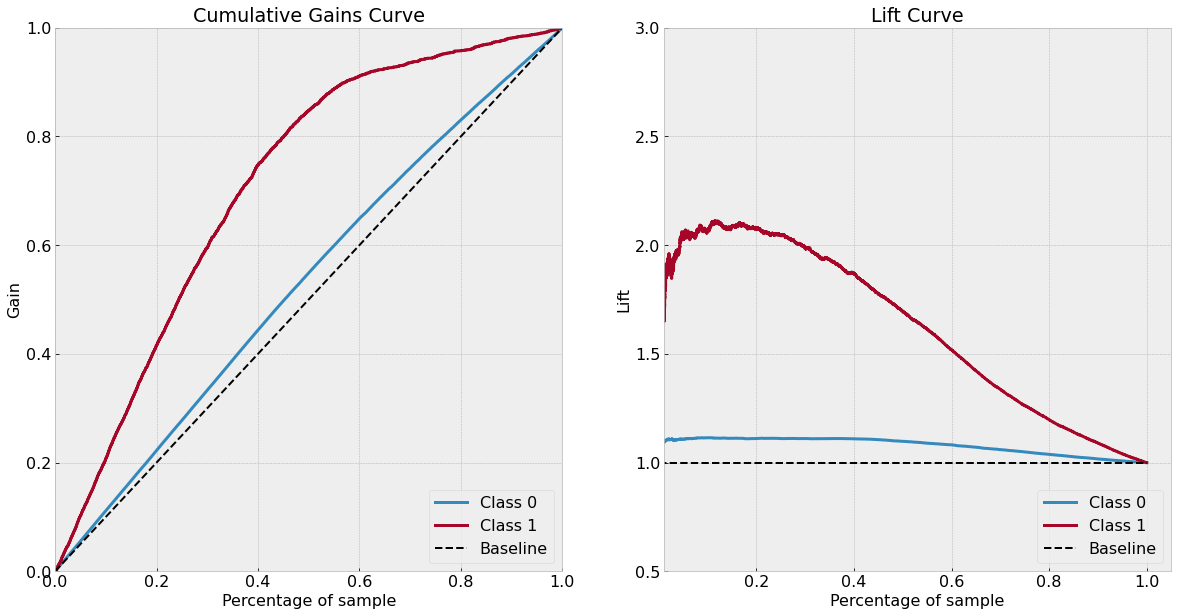

In [66]:
fig, axs = plt.subplots(ncols = 2, figsize = (20, 10))

# Cumulative gain
skplt.metrics.plot_cumulative_gain(y_valid, proba_lr, ax = axs[0])

# Lift curve
skplt.metrics.plot_lift_curve(y_valid, proba_lr, ax = axs[1])
axs[1].set_xlim(left = 0.01)
axs[1].set_ylim((0.5, 3));

In [67]:
data = pd.DataFrame({'relevant': y_valid, 'proba': proba_lr.T[1]})
data['recommended'] = data['proba'].apply(lambda x: 0 if x < 0.6 else 1)
data.sort_values('proba', ascending = False, inplace = True)

metrics_k_lr = precision_recall_k(data)

In [68]:
metrics_k_lr.loc[metrics_k_lr['k'].isin([100, 1000, 10000, 20000])]

,k,precision@k,recall@k
209654,100,0.14000,0.003724
191096,1000,0.24100,0.064113
80826,10000,0.24000,0.638468
43020,20000,0.23728,0.686087


### 7.4.1 Cross-validation

In [69]:
performance_cv_lr = cross_validation(x_train, y_train, 
                                     LogisticRegression(random_state = 73), 'Logistic regression', 
                                     kfold = 10, at_k = 2200, verbose = False)
performance_cv_lr

,Model,k,Precision@k,Recall@k
0,Logistic regression,2200,0.7 +- 0.01,0.46 +- 0.0


## 7.5 XGBoost

In [70]:
# Model training
xgb = XGBClassifier(random_state = 73)
xgb.fit(x_train, y_train)

# Prediction
proba_xgb = xgb.predict_proba(x_valid)

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:01] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


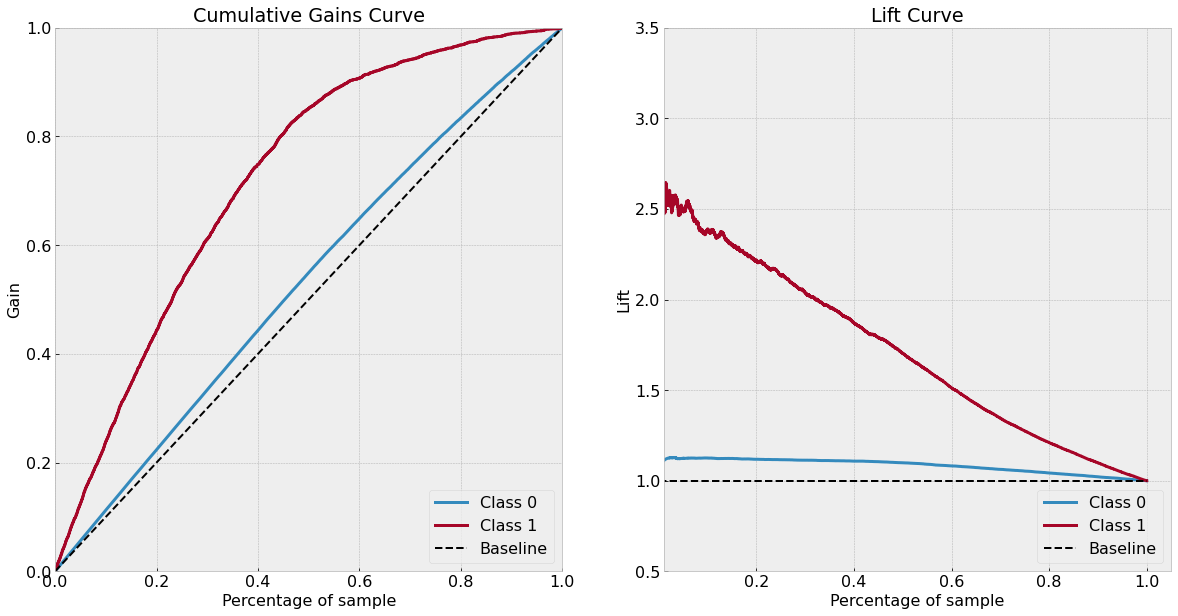

In [71]:
fig, axs = plt.subplots(ncols = 2, figsize = (20, 10))

# Cumulative gain
skplt.metrics.plot_cumulative_gain(y_valid, proba_xgb, ax = axs[0])

# Lift curve
skplt.metrics.plot_lift_curve(y_valid, proba_xgb, ax = axs[1])
axs[1].set_xlim(left = 0.01)
axs[1].set_ylim((0.5, 3.5));

In [72]:
data = pd.DataFrame({'relevant': y_valid, 'proba': proba_xgb.T[1]})
data['recommended'] = data['proba'].apply(lambda x: 0 if x < 0.6 else 1)
data.sort_values('proba', ascending = False, inplace = True)

metrics_k_xgb = precision_recall_k(data)

In [73]:
metrics_k_xgb.loc[metrics_k_xgb['k'].isin([100, 1000, 10000, 20000])]

,k,precision@k,recall@k
218083,100,0.320000,0.008513
112091,1000,0.314000,0.083533
253615,10000,0.245500,0.653099
203214,20000,0.242462,0.678106


### 7.5.1 Cross-validation

In [74]:
performance_cv_xgb = cross_validation(x_train, y_train, 
                                     XGBClassifier(random_state = 73), 'XGBoost classifier', 
                                     kfold = 10, at_k = 2200, verbose = False)
performance_cv_xgb

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:00:13] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:00:16] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:00:18] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:00:21] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

,Model,k,Precision@k,Recall@k
0,XGBoost classifier,2200,0.72 +- 0.01,0.47 +- 0.01


## 7.6 Comparação da performance

### 7.6.1 Performance única

In [75]:
k = 20000
performance_comparison = pd.concat([metrics_k_rf.loc[metrics_k_rf['k'] == k], 
                                    metrics_k_et.loc[metrics_k_et['k'] == k], 
                                    metrics_k_knn.loc[metrics_k_knn['k'] == k], 
                                    metrics_k_lr.loc[metrics_k_lr['k'] == k], 
                                    metrics_k_xgb.loc[metrics_k_xgb['k'] == k]])
performance_comparison['model'] = ['Random forest', 'Extra trees', 'KNN', 'Logistic regression', 'XGBoost']
performance_comparison = performance_comparison[['model', 'k', 'precision@k', 'recall@k']].reset_index(drop = True)
performance_comparison.sort_values('precision@k', ascending = False)

,model,k,precision@k,recall@k
4,XGBoost,20000,0.242462,0.678106
3,Logistic regression,20000,0.237280,0.686087
0,Random forest,20000,0.229570,0.595637
2,KNN,20000,0.219851,0.668795
1,Extra trees,20000,0.218731,0.587124


### 7.6.2 Cross-validation

In [76]:
performance_comparison_cv = pd.concat([performance_cv_rf, performance_cv_et, performance_cv_knn, performance_cv_lr, performance_cv_xgb])
performance_comparison_cv.sort_values('Precision@k', ascending = False)

,Model,k,Precision@k,Recall@k
0,XGBoost classifier,2200,0.72 +- 0.01,0.47 +- 0.01
0,Random forest classifier,2200,0.7 +- 0.01,0.46 +- 0.01
0,Logistic regression,2200,0.7 +- 0.01,0.46 +- 0.0
0,KNN classifier,2200,0.69 +- 0.02,0.45 +- 0.01
0,Extra trees classifier,2200,0.69 +- 0.01,0.45 +- 0.0


# 8 Ajuste fino dos hyperparâmetros

## 8.1 Método aleatório

In [77]:
params = {'n_estimators': [1500, 1700, 2500, 3000, 3500],
          'learning_rate': [0.01, 0.03, 0.05],
          'max_depth': [3, 5, 7, 9],
          'subsample': [0.1, 0.5, 0.7],
          'colsample_bytree': [0.3, 0.7, 0.9],
          'min_child_weight': [3, 7, 11, 15]}
max_eval = 10

In [78]:
final_result = pd.DataFrame()
for i in range(max_eval):
    # Choose parameters
    hp = {k: random.choice(v) for k, v in params.items()}
    print(i, hp)
    
    # Model
    xgb_model = XGBClassifier(n_estimators = hp['n_estimators'],
                              learning_rate = hp['learning_rate'],
                              max_depth = hp['max_depth'],
                              subsample = hp['subsample'],
                              colsample_bytree = hp['colsample_bytree'],
                              min_child_weight = hp['min_child_weight'])
    
    # Performance
    result = cross_validation(x_train, y_train, xgb_model, 'XGBoost classifier', kfold = 10, at_k = 2200, verbose = False)
    final_result = pd.concat([final_result, result])
final_result.reset_index(drop = True)

0 {'n_estimators': 1700, 'learning_rate': 0.03, 'max_depth': 5, 'subsample': 0.7, 'colsample_bytree': 0.7, 'min_child_weight': 3}
[15:04:43] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:05:14] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:05:47] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:06:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:06:51] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:10:36] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:07] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:11:39] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:12:11] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:17:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:19:51] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:22:05] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:24:22] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:38:16] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:38:55] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:39:35] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:40:18] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:45:43] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:12] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:46:41] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:47:10] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:50:44] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:05] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:51:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:53:44] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:04] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:23] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:54:42] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:57:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:58:26] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[15:59:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:00:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:07:19] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:08:25] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:09:33] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:10:39] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:17:32] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:17:51] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:08] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:18:26] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

,Model,k,Precision@k,Recall@k
0,XGBoost classifier,2200,0.72 +- 0.01,0.47 +- 0.0
1,XGBoost classifier,2200,0.71 +- 0.01,0.47 +- 0.0
2,XGBoost classifier,2200,0.68 +- 0.0,0.45 +- 0.0
3,XGBoost classifier,2200,0.71 +- 0.01,0.46 +- 0.01
4,XGBoost classifier,2200,0.71 +- 0.01,0.47 +- 0.01
5,XGBoost classifier,2200,0.71 +- 0.01,0.47 +- 0.01
6,XGBoost classifier,2200,0.71 +- 0.01,0.47 +- 0.01
7,XGBoost classifier,2200,0.71 +- 0.01,0.46 +- 0.01
8,XGBoost classifier,2200,0.71 +- 0.01,0.47 +- 0.01
9,XGBoost classifier,2200,0.72 +- 0.01,0.47 +- 0.01


## 8.2 Modelo final

In [23]:
tuned_params = {'n_estimators': 1700, 
                'learning_rate': 0.01, 
                'max_depth': 3, 
                'subsample': 0.5, 
                'colsample_bytree': 0.9, 
                'min_child_weight': 3}

In [24]:
# Model training
tuned_model = XGBClassifier(n_estimators = tuned_params['n_estimators'],
                            learning_rate = tuned_params['learning_rate'],
                            max_depth = tuned_params['max_depth'],
                            subsample = tuned_params['subsample'],
                            colsample_bytree = tuned_params['colsample_bytree'],
                            min_child_weight = tuned_params['min_child_weight'])
tuned_model.fit(x_train, y_train)

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:24:17] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=3,
              min_child_weight=3, missing=nan, monotone_constraints='()',
              n_estimators=1700, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
pickle.dump(tuned_model, open('../src/models/health_insurance_model.pkl', 'wb'))

## 8.3 Cross-validation

In [27]:
tuned_model = XGBClassifier(n_estimators = tuned_params['n_estimators'],
                            learning_rate = tuned_params['learning_rate'],
                            max_depth = tuned_params['max_depth'],
                            subsample = tuned_params['subsample'],
                            colsample_bytree = tuned_params['colsample_bytree'],
                            min_child_weight = tuned_params['min_child_weight'])
tubed_performance_cv = cross_validation(x_train, y_train, 
                                        tuned_model, 'XGBoost classifier', 
                                        kfold = 10, at_k = 2200, verbose = False)
tubed_performance_cv

C:\Users\lucas\anaconda3\envs\insurance-cross-sell\lib\site-packages\xgboost\sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:25:28] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:25:48] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:07] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:26:27] WARNING: D:\bld\xgboost-split_1631904903843\work\src\learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation me

,Model,k,Precision@k,Recall@k
0,XGBoost classifier,2200,0.72 +- 0.01,0.47 +- 0.0


# 9 Performance do modelo final

## Data checkpoint

In [5]:
selected_features = ['vintage', 'annual_premium', 'age', 'region_code', 'policy_sales_channel']
tuned_model = pickle.load(open('../src/models/health_insurance_model.pkl', 'rb'))

## 9.1 Dados de teste

In [28]:
df_test = pd.read_csv('../data/processed/test.csv')

In [29]:
# Feature engineering
df_test['vehicle_age'] = df_test['vehicle_age'].apply(lambda x: 1 if x == '< 1 Year' else 
                                                                2 if x == '1-2 Year' else
                                                                3)
df_test['vehicle_damage'] = df_test['vehicle_damage'].apply(lambda x: 0 if x == 'No' else 1)

In [30]:
# Preparação dos dados
features_path = '../src/features/'
age_scaler = pickle.load(open(features_path+'age_scaler.pkl', 'rb'))
annual_premium_scaler = pickle.load(open(features_path+'annual_premium_scaler.pkl', 'rb'))
vintage_scaler = pickle.load(open(features_path+'vintage_scaler.pkl', 'rb'))
gender_encoder = pickle.load(open(features_path+'gender_encoder.pkl', 'rb'))
region_encoder = pickle.load(open(features_path+'region_encoder.pkl', 'rb'))
sales_encoder = pickle.load(open(features_path+'sales_encoder.pkl', 'rb'))

# annual_premium
df_test['annual_premium'] = annual_premium_scaler.transform(df_test[['annual_premium']].values)

# vintage
df_test['vintage'] = vintage_scaler.transform(df_test[['vintage']].values)

# age
df_test['age'] = age_scaler.transform(df_test[['age']].values)

# region_code - target encoding
df_test.loc[:, 'region_code'] = df_test['region_code'].map(region_encoder)

# policy_sales_channel - target encoding
df_test.loc[:, 'policy_sales_channel'] = df_test['policy_sales_channel'].map(sales_encoder)

# gender - label encoding
df_test['gender'] = df_test['gender'].map(gender_encoder)

In [31]:
x_test = df_test[selected_features].copy()
y_test = df_test['response'].copy()

## 9.2 Performance

In [32]:
# Prediction
proba_tuned_model = tuned_model.predict_proba(x_test)

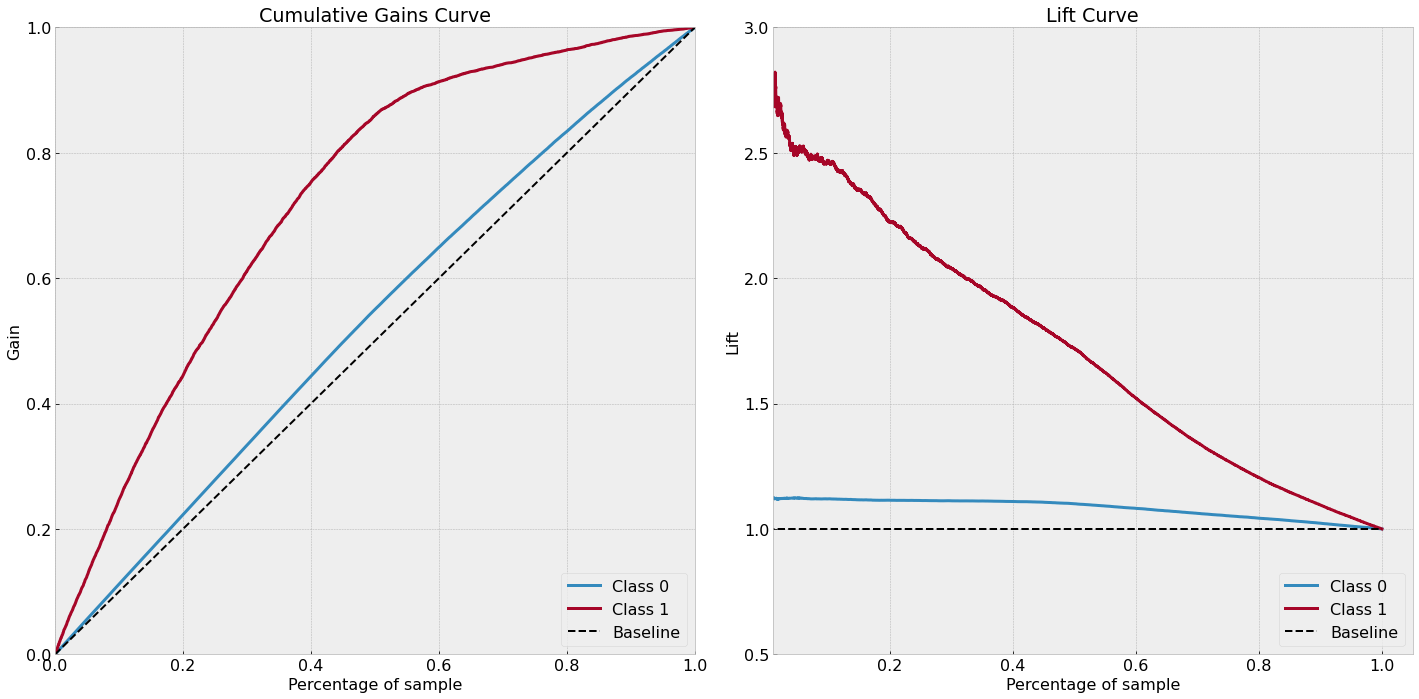

In [92]:
fig, axs = plt.subplots(ncols = 2, figsize = (20, 10))

# Cumulative gain
skplt.metrics.plot_cumulative_gain(y_test, proba_tuned_model, ax = axs[0])

# Lift curve
skplt.metrics.plot_lift_curve(y_test, proba_tuned_model, ax = axs[1])
axs[1].set_xlim(left = 0.01)
axs[1].set_ylim((0.5, 3))

fig.tight_layout()
fig.savefig('../reports/figures/gain_lift.png', facecolor = 'w')

In [42]:
df9 = pd.DataFrame({'relevant': y_test, 'proba_0': proba_tuned_model.T[0], 'proba_1': proba_tuned_model.T[1]})

In [44]:
# Count relevant recomendations
df9 = df9.sort_values('proba_1', ascending = False).reset_index()
df9['percentage_of_sample'] = df9.index/len(df9)
df9['relevant_count'] = df9['relevant'].cumsum()

# Gain and lift
df9['gain'] = df9['relevant_count']/df9['relevant_count'].max()
df9['lift'] = df9['gain']/df9['percentage_of_sample']

In [45]:
sample = 0.5
print('Sample: {:.1f}%'.format(sample*100))
print('Gain: {:.2f}'.format(np.interp(sample, df9['percentage_of_sample'], df9['gain'])))
print('Lift: {:.2f}'.format(np.interp(sample, df9['percentage_of_sample'], df9['lift'])))

Sample: 50.0%
Gain: 0.86
Lift: 1.72


### 9.2.1 Figura gain e lift

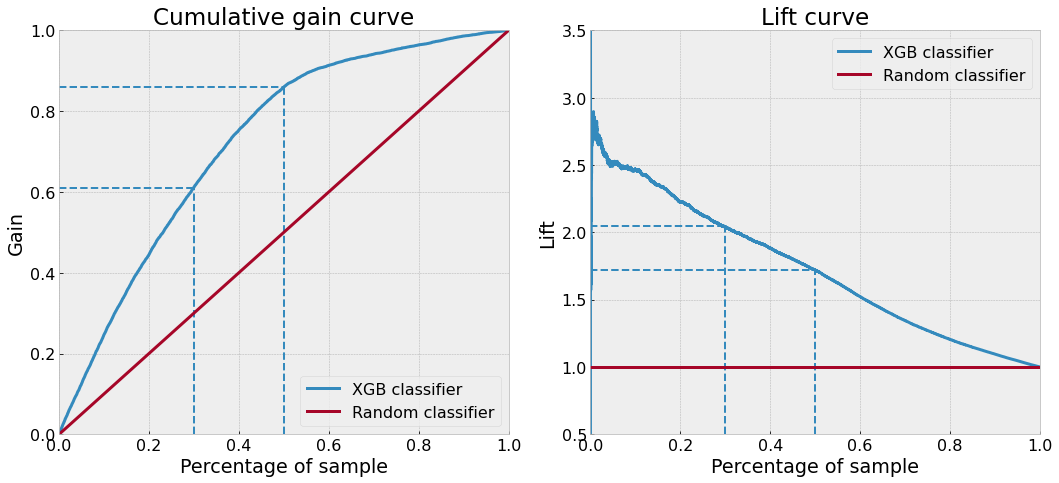

In [39]:
fig, axs = plt.subplots(ncols = 2)

# Cumulative gain
df9.plot(x = 'percentage_of_sample', y = 'gain', 
         ax = axs[0], grid = True, 
         xlim = (0, 1), ylim = (0, 1), 
         xlabel = 'Percentage of sample', ylabel = 'Gain', title = 'Cumulative gain curve', 
         label = 'XGB classifier', lw = 3)
draw_coords(0.3, 0.61, axs[0])
draw_coords(0.5, 0.86, axs[0])
axs[0].plot([0, 1], [0, 1], lw = 3, label = 'Random classifier')
axs[0].legend(loc = 'lower right')

# Lift curve
df9.plot(x = 'percentage_of_sample', y = 'lift', 
         ax = axs[1], grid = True, 
         xlim = (0, 1), ylim = (0.5, 3.5), 
         xlabel = 'Percentage of sample', ylabel = 'Lift', title = 'Lift curve', 
         label = 'XGB classifier', lw = 3)
draw_coords(0.3, 2.05, axs[1])
draw_coords(0.5, 1.72, axs[1])
axs[1].plot([0, 1], [1, 1], lw = 3, label = 'Random classifier')
axs[1].legend()

fig.tight_layout()
fig.savefig('../reports/figures/gain_lift.png', facecolor = 'w')

In [40]:
sample = 20000/len(y_test)
sample = 0.5
print('Sample: {:.1f}%'.format(sample*100))
print('Gain:', np.interp(sample, df9['percentage_of_sample'], df9['gain']))
print('Lift:', np.interp(sample, df9['percentage_of_sample'], df9['lift']))

Sample: 50.0%
Gain: 0.8597299614230605
Lift: 1.719459922846121


## 9.3 Questões de negócio

### 9.3.1 Qual o percentual de interesados o time de vendas alcança com 20 mil ligações?

In [48]:
calls = 20000
sample = calls/len(y_test)
print('Sample: {:.1f}%'.format(sample*100))
print('Gain:', np.interp(sample, df9['percentage_of_sample'], df9['gain']))
print('Lift:', np.interp(sample, df9['percentage_of_sample'], df9['lift']))

Sample: 26.2%
Gain: 0.5531504500642949
Lift: 2.108111680240034


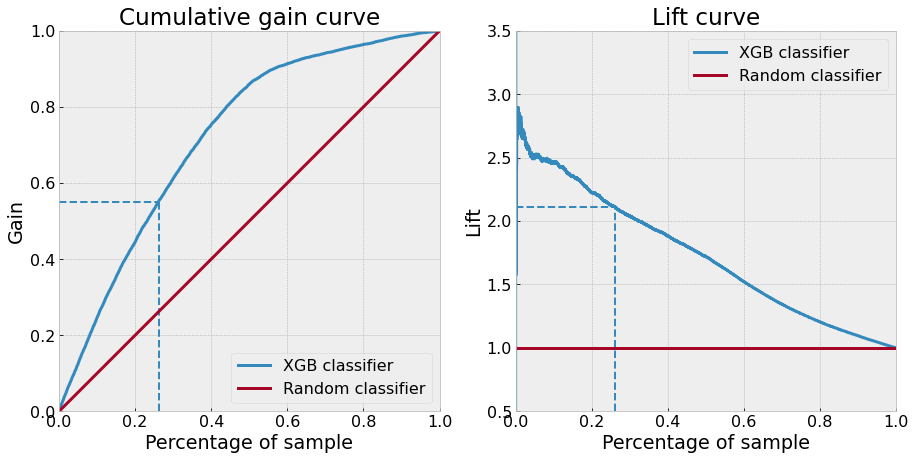

In [55]:
fig, axs = plt.subplots(ncols = 2)

# Cumulative gain
df9.plot(x = 'percentage_of_sample', y = 'gain', 
         ax = axs[0], grid = True, 
         xlim = (0, 1), ylim = (0, 1), 
         xlabel = 'Percentage of sample', ylabel = 'Gain', title = 'Cumulative gain curve', 
         label = 'XGB classifier', lw = 3)
draw_coords(0.262, 0.55, axs[0])
axs[0].plot([0, 1], [0, 1], lw = 3, label = 'Random classifier')
axs[0].legend(loc = 'lower right')

# Lift curve
df9.plot(x = 'percentage_of_sample', y = 'lift', 
         ax = axs[1], grid = True, 
         xlim = (0, 1), ylim = (0.5, 3.5), 
         xlabel = 'Percentage of sample', ylabel = 'Lift', title = 'Lift curve', 
         label = 'XGB classifier', lw = 3)
draw_coords(0.262, 2.11, axs[1])
axs[1].plot([0, 1], [1, 1], lw = 3, label = 'Random classifier')
axs[1].legend()

### 9.3.2 Qual seria o percentual de interessados se a capacidade aumentasse para 40 mil ligações?

In [56]:
calls = 40000
sample = calls/len(y_test)
print('Sample: {:.1f}%'.format(sample*100))
print('Gain:', np.interp(sample, df9['percentage_of_sample'], df9['gain']))
print('Lift:', np.interp(sample, df9['percentage_of_sample'], df9['lift']))

Sample: 52.5%
Gain: 0.877089584226318
Lift: 1.67133805722246


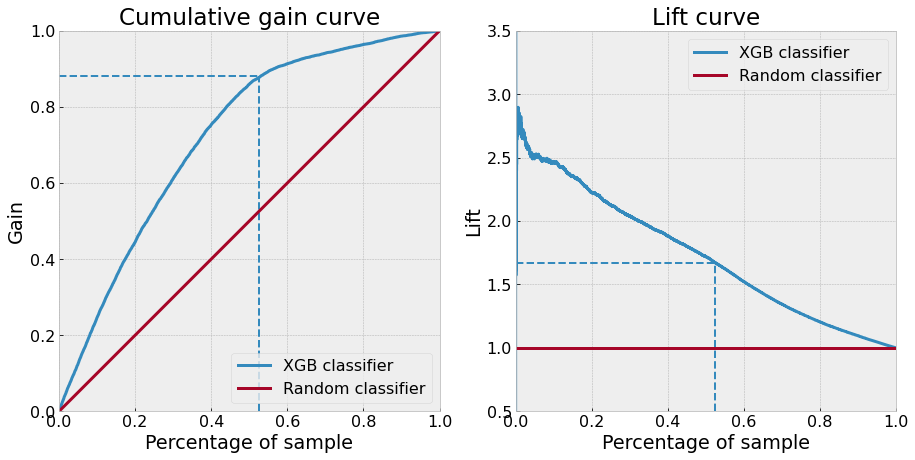

In [57]:
fig, axs = plt.subplots(ncols = 2)

# Cumulative gain
df9.plot(x = 'percentage_of_sample', y = 'gain', 
         ax = axs[0], grid = True, 
         xlim = (0, 1), ylim = (0, 1), 
         xlabel = 'Percentage of sample', ylabel = 'Gain', title = 'Cumulative gain curve', 
         label = 'XGB classifier', lw = 3)
draw_coords(0.525, 0.88, axs[0])
axs[0].plot([0, 1], [0, 1], lw = 3, label = 'Random classifier')
axs[0].legend(loc = 'lower right')

# Lift curve
df9.plot(x = 'percentage_of_sample', y = 'lift', 
         ax = axs[1], grid = True, 
         xlim = (0, 1), ylim = (0.5, 3.5), 
         xlabel = 'Percentage of sample', ylabel = 'Lift', title = 'Lift curve', 
         label = 'XGB classifier', lw = 3)
draw_coords(0.525, 1.67, axs[1])
axs[1].plot([0, 1], [1, 1], lw = 3, label = 'Random classifier')
axs[1].legend()

### 9.3.3 Quantas ligações o time de vendas precisa fazer para alcançar 80% dos interessados em comprar o seguro?

In [90]:
gain = .8
sample = np.interp(gain, df9['gain'], df9['percentage_of_sample'])
calls = sample*len(y_test)
print('Sample: {:.1f}% ({} calls)'.format(sample*100, calls))
print('Gain:', np.interp(sample, df9['percentage_of_sample'], df9['gain']))
print('Lift:', np.interp(sample, df9['percentage_of_sample'], df9['lift']))

Sample: 44.0% (33544.6 calls)
Gain: 0.7999999999999999
Lift: 1.8178067395219395


# 10 Modelo em produção

## 10.1 API tester

In [1]:
import json
import pandas as pd
import requests

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]
plt.rcParams['font.size'] = 16

def plot_gain_lift(y_relevant, score):
    d1 = pd.DataFrame({'relevant': y_relevant, 'score': score})
    d1 = d1.sort_values('score', ascending = False).reset_index()
    d1['percentage_of_sample'] = d1.index/len(d1)
    d1['relevant_count'] = d1['relevant'].cumsum()
    d1['gain'] = d1['relevant_count']/d1['relevant_count'].max()
    d1['lift'] = d1['gain']/d1['percentage_of_sample']

    fig, axs = plt.subplots(ncols = 2)

    # Cumulative gain
    d1.plot(x = 'percentage_of_sample', y = 'gain', 
            ax = axs[0], grid = True, 
            xlim = (0, 1), ylim = (0, 1), 
            xlabel = 'Percentage of sample', ylabel = 'Gain')

    # Lift curve
    d1.plot(x = 'percentage_of_sample', y = 'lift', 
            ax = axs[1], grid = True, 
            xlim = (0, 1), ylim = (0.5, 3.5), 
            xlabel = 'Percentage of sample', ylabel = 'Lift')

In [3]:
# Load data
df10 = pd.read_csv('../data/processed/test.csv')
y_test = df10['response']
df_test = df10.drop('response', axis = 1)

In [4]:
# Convert dataframe to json
data = json.dumps(df_test.to_dict(orient = 'records'))

In [5]:
# API call
# url = 'http://127.0.0.1:5000/predict'
url = 'https://health-insurance-cs.herokuapp.com/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data = data, headers = header)
print('Status code {}'.format(r.status_code))

Status code 200


In [6]:
d1 = pd.DataFrame(r.json(), columns = r.json()[0].keys())

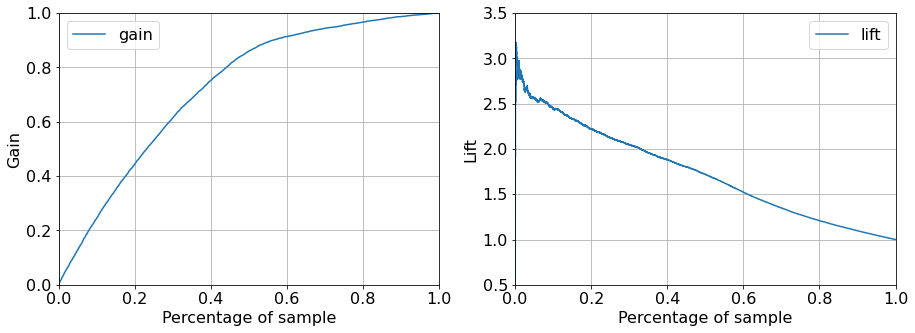

In [7]:
plot_gain_lift(y_test, d1['score'])